# **Grid Search for Optimizing $\alpha$ and $\lambda_{dB}$ Combinations**

In [104]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

### **Define Useful Functions**

In [105]:
""" Plotting """
def plot_wigner(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    fig.tight_layout()
    
    plt.show()
    
def ax_plot_wigner(ax, state, title, range=20):
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    
# plot  Wigner function on 2D surface
def plot_wigner_2d(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, P, Z, cmap='RdYlGn')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    # add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Wigner Function')
    
    fig.tight_layout()
    
    plt.show()
    
def ax_plot_wigner_2d(ax, state, title, range = 20):
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    contour = ax.contourf(X, P, Z, cmap='RdYlGn')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    # add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Wigner Function')
    # set axis to have equal aspect ratio
    ax.set_aspect('equal')
    
def plot_sf_state(state, backend = "fock", cutoff_dim = 40):
    prog = sf.Program(1)
    with prog.context as q:
        state | q[0]
    eng = sf.Engine(backend, backend_options={"cutoff_dim": cutoff_dim})
    result = eng.run(prog)
    plot_wigner(result.state, title = "Wigner Function of State")
    
def plot_kets_reim(simstate, target_state):
    simket = simstate.ket()
    targetket = target_state.ket()

    # plot the real and imaginary parts of the state
    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Comparison of Simulated and Target States")
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(np.real(simket), label = "Simulated")
    ax1.plot(np.real(targetket), label = "Target")
    ax1.set_title("Real Part")
    ax2.plot(np.imag(simket), label = "Simulated")
    ax2.plot(np.imag(targetket), label = "Target")
    ax2.set_title("Imaginary Part")
    plt.legend()
    plt.grid()
    plt.show()
    
# plot ket amplitude and phase
def plot_ket(simstate, target_state):
    simket = simstate.ket()
    targetket = target_state.ket()

    # plot the amplitude and phase of the state
    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Comparison of Simulated and Target States")
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(np.abs(targetket), label = "Target", color = 'b')
    ax1.plot(np.abs(simket), label = "Simulated", linestyle = "--", color = 'coral')
    ax1.set_title("Amplitude")
    ax2.plot(np.angle(targetket), label = "Target", color = 'b')
    ax2.plot(np.angle(simket), label = "Simulated", linestyle = "--", color = 'coral')
    ax2.set_title("Phase")
    plt.legend()
    plt.grid()
    plt.show()

In [106]:
""" Other """
def get_fidelity_error(state1, state2, backend = "fock"):
    return 1 - state1.fidelity(other_state = state2.ket(), mode = 0).numpy().item() if backend == "tf" else 1 - state1.fidelity(other_state = state2.ket(), mode = 0)

def get_ket_error(state1, state2):
    return np.linalg.norm(state1.ket() - state2.ket()) # returns L2 norm of difference

def get_inner_product_error(state1, state2):
    return 1 - np.abs(np.vdot(state1.ket() / np.linalg.norm(state1.ket()), state2.ket() / np.linalg.norm(state2.ket()))) # returns 1 - inner product of normalized states
    
def get_wigner_error(state1, state2):
    x = np.linspace(-20, 20, 100)
    p = np.linspace(-20, 20, 100)
    Z1 = state1.wigner(0, x, p)
    Z2 = state2.wigner(0, x, p)
    return np.linalg.norm(Z1 - Z2) # returns L2 norm of wigner difference

### **Define Streamlined Function Run**

In [107]:
def simulate_cubic_phase_gate(
    N,
    cutoff_dim,
    backend,
    start_state,
    gamma,
    lamdB,
    alpha,
    chi,
    sqphi=0,
    phi=0,
    ndphi=3 * np.pi / 2
):
    """
    Simulate a cubic phase gate via a sequence of squeezing, displacement, 
    and nonlinear steps, and compare it to the ideal cubic phase gate.

    Parameters:
        N (int): Number of discretization steps.
        cutoff_dim (int): Fock basis truncation dimension.
        backend (str): Backend to use (e.g. "fock").
        start_state: The initial state (e.g. sf.ops.GKP([0,0]), sf.ops.Catstate(), etc.).
        gamma (float): Target gate angle for the cubic phase gate.
        lamdB (float): Squeezing level in dB.
        alpha (float): Displacement amplitude along x.
        chi (float): Nonlinearity strength.
        sqphi (float, optional): Squeezing phase. Default is 0.
        phi (float, optional): Displacement phase. Default is 0.
        ndphi (float, optional): Displacement phase for the nonlinear step. Default is 3π/2.

    Returns:
        tuple: (simstate, target_state)
            simstate: State after applying the approximated cubic phase gate.
            target_state: State after applying the ideal cubic phase gate.
    """
    # Calculate squeezing parameters
    lam = np.sqrt(10 ** (lamdB / 10))
    rsq = -np.log(lam)
    
    # Displacement amplitude in r-form
    rd = np.abs(alpha)
    
    # Calculate detuning and drive for the nonlinear step
    detuning = 3 * chi * alpha**2 - chi
    drive = -2 * chi * alpha**3
    
    # Gate time and time step
    t = np.sqrt(2) * gamma / (chi * alpha * lam**3)
    dt = t / N
    
    # Parameters for the cubic phase gate step
    nkappa = chi / 2.0 * dt
    nrphi = -detuning * dt
    nr = drive * dt
    
    # Build the simulation program (approximate cubic phase gate)
    prog = sf.Program(1)
    with prog.context as q:
        start_state | q[0]
        # Direct operations: squeezing then displacement
        Sgate(rsq, sqphi) | q[0]
        Dgate(rd, phi) | q[0]
        
        # Nonlinear step(s)
        for i in range(N):
            Rgate(-chi / 2 * dt) | q[0]
            Kgate(nkappa) | q[0]
            Rgate(nrphi) | q[0]
            Dgate(nr, ndphi) | q[0]
        
        # Inverse operations: displacement then squeezing
        Dgate(-rd, phi) | q[0]
        Sgate(-rsq, sqphi) | q[0]
    
    eng = sf.Engine(backend, backend_options={"cutoff_dim": cutoff_dim})
    simstate = eng.run(prog).state
    
    # Build the target program (ideal cubic phase gate)
    prog_target = sf.Program(1)
    with prog_target.context as q:
        start_state | q[0]
        Vgate(gamma) | q[0]
    
    eng_target = sf.Engine(backend, backend_options={"cutoff_dim": cutoff_dim})
    target_state = eng_target.run(prog_target).state
    
    return simstate, target_state

### **Conducting Grid Search**

In [108]:
""" Hyperparameters """
N = 10
ALPHA_DISCRET = 50
LAMBDA_DISCRET = 8
CUTOFF = 60 # Fock basistruncation
alpha_range = (0.5, 4.0) # range for alpha values to test
lambda_range = (3, 10) # range for squeezing level in dB

backend = "fock" # backend to use
gamma = 0.7 # target gate angle
start_state = sf.ops.Vacuum() # starting state for the simulation, can be a GKP or Catstate etc.
chi = 0.001 # scales t 
error_fn = get_inner_product_error # error function to use for comparison


""" Setup """
lamdBs = np.linspace(lambda_range[0], lambda_range[1], LAMBDA_DISCRET) # squeezing levels in dB
alphas = np.linspace(alpha_range[0], alpha_range[1], ALPHA_DISCRET) # displacement amplitudes   

min_alphas = []
min_errs = []
err_lists = []

def run(lamdB, alpha):
    # Simulate the cubic phase gate with the given parameters
    simstate, target_state = simulate_cubic_phase_gate(
        N, CUTOFF, backend, start_state, gamma, lamdB, alpha, chi
    )
    
    # Calculate the error between the simulated and target states
    err = error_fn(simstate, target_state)
    
    return err

In [109]:
""" Run Simulation """
for i, lamdB in enumerate(tqdm(lamdBs, desc="Squeezing Levels")):
    err_list = []
    for j, alpha in enumerate(tqdm(alphas, desc="Displacement Amplitudes", leave=False)):
        err_list.append(run(lamdB, alpha))
    
    # retrieve minimum error index and corresponding alpha and error
    min_index = np.argmin(err_list)
    min_err = min(err_list)
    min_alpha = alphas[min_index]
    
    # append to lists
    min_alphas.append(min_alpha)
    min_errs.append(min_err) 
    
    err_lists.append(err_list) # store the error list for each squeezing level


Squeezing Levels: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


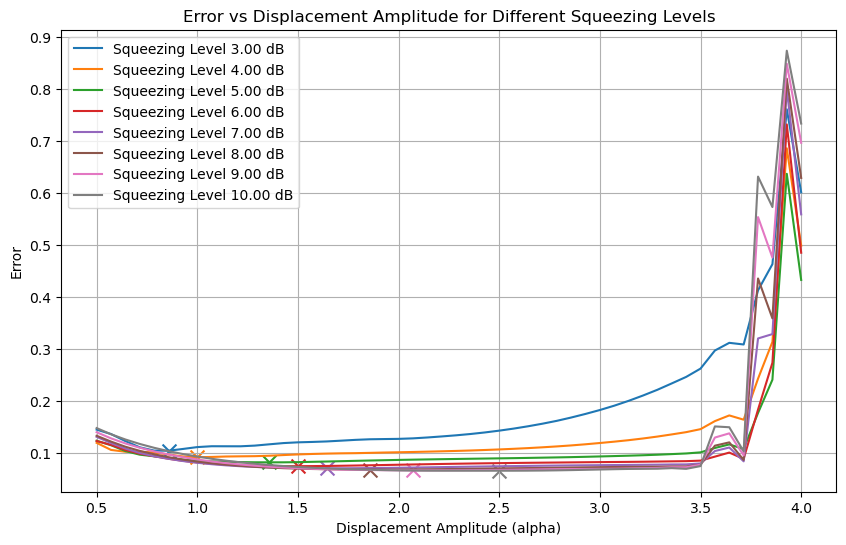

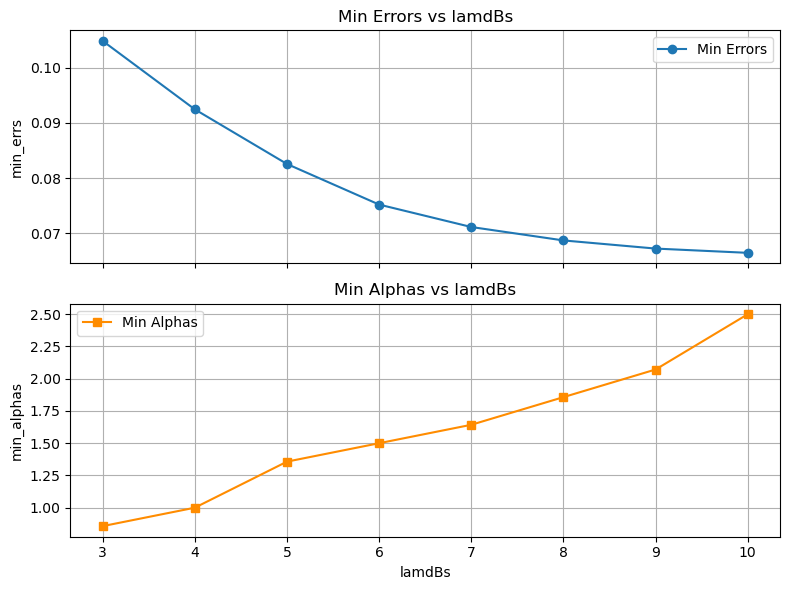

<Figure size 640x480 with 0 Axes>

In [110]:
""" Plotting Results """
# plot error curves
fig = plt.figure(figsize=(10, 6))
for i, lamdB in enumerate(lamdBs):
    plt.plot(alphas, err_lists[i], label=f"Squeezing Level {lamdB:.2f} dB")
    plt.scatter(min_alphas[i], min(err_lists[i]), color = "C{}".format(i), marker = "x", s = 100)
plt.title("Error vs Displacement Amplitude for Different Squeezing Levels")
plt.xlabel("Displacement Amplitude (alpha)")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.savefig("grid_out/gkp_{}_simrun_a{}to{}and{}to{}_with{}.png".format(backend, alpha_range[0], alpha_range[1], lambda_range[0], lambda_range[1], CUTOFF))
plt.show()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top subplot: min_errs vs lamdBs
ax1.plot(lamdBs, min_errs, marker='o', linestyle='-', label='Min Errors')
ax1.set_ylabel('min_errs')
ax1.set_title('Min Errors vs lamdBs')
ax1.grid(True)
ax1.legend()

# Bottom subplot: min_alphas vs lamdBs
ax2.plot(lamdBs, min_alphas, marker='s', linestyle='-', color='darkorange', label='Min Alphas')
ax2.set_xlabel('lamdBs')
ax2.set_ylabel('min_alphas')
ax2.set_title('Min Alphas vs lamdBs')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
plt.savefig("grid_out/gkp_{}_simrun_a{}to{}and{}to{}_with{}_summary.png".format(backend, alpha_range[0], alpha_range[1], lambda_range[0], lambda_range[1], CUTOFF))
